In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#  Histogram of Oriented Gradients

In [5]:
from skimage import color, data, feature

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize = True)


Text(0.5, 1.0, 'hog features')

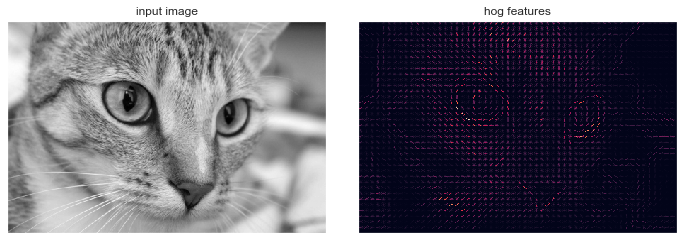

In [7]:
fig, ax = plt.subplots(1,2,figsize = (12, 6),
                      subplot_kw = {'xticks':[], 'yticks':[]},
                      gridspec_kw = dict(hspace = 0.1, wspace = 0.1))
ax[0].imshow(image, cmap ='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('hog features')

In [8]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [9]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

/Users/Pengfei/opt/anaconda3/envs/mlvenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  import sys


In [13]:
from sklearn.feature_extraction.image import PatchExtractor

In [15]:
def extract_patches(img, N, scale = 1, patch_size = positive_patches[0].shape):
    extracted_patch_size = tuple((scale*np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size = extracted_patch_size, 
                              max_patches = N, random_state = 0)
    patches = extractor.transform(img[np.newaxis])
    if scale!=1  :
        patches = np.array([transform.resize(patch, patch_size)
                           for patch in patches])
    return patches
negative_patches = np.vstack([extract_patches(im, 1000, scale) 
                             for im in images for scale in [0.5,1,2]])
negative_patches.shape

(30000, 62, 47)

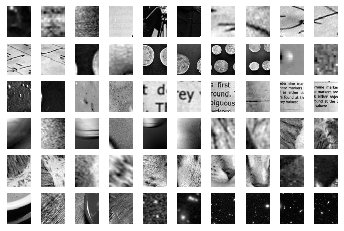

In [18]:
fig, ax = plt.subplots(6,10)
for i, ax in enumerate(ax.flat):
    ax.imshow(negative_patches[500*i], cmap = 'gray')
    ax.axis('off')

In [19]:
from itertools import chain
X_train = np.array([feature.hog(im)
                  for im in chain(positive_patches,
                                 negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [20]:
X_train.shape

(43233, 1215)

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), X_train, y_train)

array([0.94772754, 0.97189777, 0.97236036, 0.97490169, 0.97374508])

In [25]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C':[1.0,2.0,4.0,8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/Users/Pengfei/opt/anaconda3/envs/mlvenv/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Pengfei/opt/anaconda3/envs/mlvenv/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Pengfei/opt/anaconda3/envs/mlvenv/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Pengfei/opt/anaconda3/envs/mlvenv/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/Pengfei/opt/anaconda3/envs/mlvenv/lib/python3.7/site-packages/sklearn

0.9884578497284486

In [26]:
grid.best_params_

{'C': 1.0}

In [27]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC()

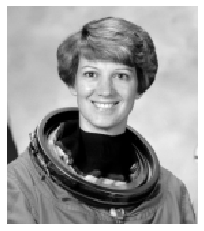

In [31]:
import skimage
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [34]:
def sliding_window(img, patch_size = positive_patches[0].shape, 
                  istep = 2, jstep =2, scale =1.0):
    Ni, Nj = (int(scale*s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1]-Nj, jstep):
            patch = img[i:i+Ni, j:j+Nj]
            if scale !=1:
                patch = transform(patch,patch_size)
            yield (i,j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(2303, 1215)

In [35]:
labels = model.predict(patches_hog)
labels.sum()

49.0

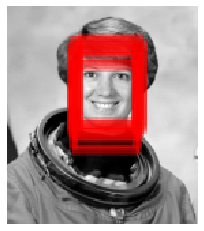

In [36]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap = 'gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j,i), Nj, Ni, edgecolor = 'red',
                              alpha = 0.3, lw = 3, facecolor = 'None'))

In [44]:
np.array([patches]).shape


(1, 2303, 62, 47)